In [1]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup

from mwReconstruction.dataloader import destripeDataSet
from mwReconstruction.model import *

import numpy as np
import matplotlib.pyplot as plt
import random
import mrcfile
import pandas as pd
import torch
from torch.utils.data import Dataset
import os
from glob import glob
import scipy.io as io
# from skimage.metrics import structural_similarity as ssim
# from skimage.metrics import normalized_mutual_information as nmi
from scipy import ndimage
from joblib import Parallel, delayed

from PIL import Image

PARENT_PATH = setup.PARENT_PATH
ISONET_PATH = os.path.join(PARENT_PATH, 'data/isoNet/')

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

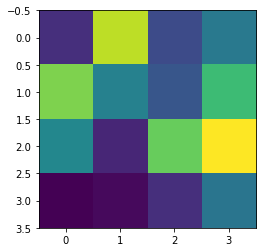

In [57]:
# X = np.array(Image.open(os.path.join(PARENT_PATH, 'data/sample_small_image.png')))[:,:,1]
X = torch.rand(4, 4)
fX = fft.fftshift(fft.fft2(X))
m,n = X.shape

dummy_symmatrix = make_symmatrix(n, m)
dummy_symmask = torch.from_numpy(dummy_symmatrix).float()

plt.imshow(X)

In [66]:
r = m+1 if m%2==0 else m
r

5

In [58]:
def neg2full_spectrum(x_neg, m, n):
    if m%2==0:
        r = m+1
    else:
        r = m

    if n%2==0:
        s = n+1
    else:
        s = n

    aux_symmatrix = make_symmatrix(s, r)
    aux_symmask = torch.from_numpy(aux_symmatrix).float()
    
    x_neg = x_neg.repeat(2)[0:(aux_symmask==-1).sum()]

    new_img = (aux_symmask).type(torch.complex128)
    new_img[torch.where(aux_symmask==-1)] = x_neg.type(torch.complex128)

    new_img = torch.flip(new_img, [0, 1])

    new_img[torch.where(new_img==1)] = torch.conj(x_neg).type(torch.complex128)
    new_img = torch.flip(new_img, [1, 0])

    new_img[r//2, s//2] = X.sum()

    return new_img[0:m, 0:n]

In [59]:
x_neg = fX[dummy_symmask==-1]
x_neg

tensor([-0.4467+0.0000j, -0.7431+0.1997j,  1.1546+0.0000j, -0.9834+0.2074j,
         0.0886+1.9040j, -0.6223+1.5191j, -1.0584+0.0000j,  0.0029-0.9336j,
        -0.9834-0.2074j,  0.3040+0.6584j])

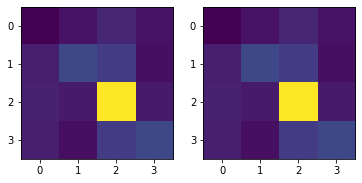

In [65]:
new_img = neg2full_spectrum(x_neg, m, n)

fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(torch.abs(fX))
ax1.imshow(torch.abs(new_img))

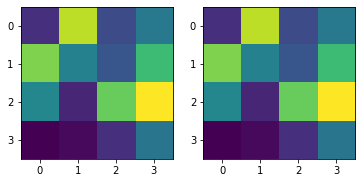

In [62]:
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(fft.ifft2(fft.ifftshift(fX)).real)
ax1.imshow(fft.ifft2(fft.ifftshift(new_img)).real)